In [1]:
#Imports
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt 
import scipy
from astropy.table import Table

In [2]:
"""
Loading TNG 100-3
"""

basePath = 'D:/Buhv2020Work/Illustris-3/output'
snapshot_ind = 99 #redshift ?

#Header gives basic group info
header = il.groupcat.loadHeader(basePath, snapshot_ind)
#Scale Factor
scale_factor = header['Time']

#Load in the subhalo/halo tables
subhalo_grp = il.groupcat.loadSubhalos(basePath, snapshot_ind)
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind)

#Get the keys for each
subhalo_keys = (list(subhalo_grp.keys()))
halo_keys = (list(halo_grp.keys()))

#Index the table
subhalo_table = Table({'Index': [x+1 for x in range(subhalo_grp['count'])]})
#Tabulate the subhalo info
for i in range(1, len(subhalo_keys)):
    subhalo_table.add_column(subhalo_grp[str(subhalo_keys[i])], name=str(subhalo_keys[i]))

#Tabulate the halo info
halo_table = Table({'Index': [x+1 for x in range(halo_grp['count'])]})
for i in range(1, len(halo_keys)):
    halo_table.add_column(halo_grp[str(halo_keys[i])], name=str(halo_keys[i]))
    
    subhalo_data = [0] * len(subhalo_table)
    for j in range(0, len(subhalo_table)):
        subhalo_data[j] = halo_table[halo_keys[i]][subhalo_table['SubhaloGrNr'][j]]
    subhalo_table.add_column(subhalo_data,name=str(halo_keys[i]))

is_central = np.array([0] * len(subhalo_table), dtype=bool)
temp = halo_table['GroupFirstSub']>-1
is_central[halo_table[temp]['GroupFirstSub']]=True
subhalo_table.add_column(is_central,name=str("IsCentral"))


In [28]:
print(len(subhalo_table))
all_galaxies = subhalo_table[subhalo_table['SubhaloFlag']]
all_galaxies = all_galaxies[all_galaxies['SubhaloMass']!=0]
all_galaxies = all_galaxies[all_galaxies['SubhaloMassType'][:,4]!=0]
print(len(all_galaxies))
print('Masking step 1 - remove bad subhalos - complete \n')

centrals = all_galaxies[all_galaxies['IsCentral']]
satellites = all_galaxies[np.bitwise_not(all_galaxies['IsCentral'])]
centrals_in_cluster = centrals[centrals['GroupNsubs']>1]
print("Central galaxies: " + str(len(centrals)))
print("Satellite galaxies: " + str(len(satellites)))
print("Central galaxies that are not alone in their halo: " + str(len(centrals_in_cluster)))
print("Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete \n")

centrals_red = cut_color_lines(centrals, 0.6, 1000)
centrals_blue = cut_color_lines(centrals, 0, 0.5)

satellites_red = cut_color_lines(satellites, 0.6, 1000)
satellites_blue = cut_color_lines(satellites, 0, 0.5)

centrals_in_cluster_red = cut_color_lines(centrals_in_cluster, 0.6, 1000)
centrals_in_cluster_blue = cut_color_lines(centrals_in_cluster, 0, 0.5)

print("Central galaxies red: " + str(len(centrals_red)))
print("Central galaxies blue: " + str(len(centrals_blue)))

print("Satellite galaxies red: " + str(len(satellites_red)))
print("Satellite galaxies blue: " + str(len(satellites_blue)))

print("Central galaxies that are not alone in their halo red: " + str(len(centrals_in_cluster_red)))
print("Central galaxies that are not alone in their halo blue: " + str(len(centrals_in_cluster_blue)))

print("Masking step 3 - color bimodality for each type of galaxy, complete \n")

#Compare particle numbers between central solitaries 

118820
21661
Masking step 1 - remove bad subhalos - complete 

Central galaxies: 13542
Satellite galaxies: 8119
Central galaxies that are not alone in their halo: 4491
Masking step 2 - separate all centrals, satellites, and centrals with satellites in same halo, complete 

Central galaxies red: 2098
Central galaxies blue: 7239
Satellite galaxies red: 2535
Satellite galaxies blue: 3292
Central galaxies that are not alone in their halo red: 1179
Central galaxies that are not alone in their halo blue: 2200
Masking step 3 - color bimodality for each type of galaxy, complete 



In [26]:
def cut_color_lines(table, min_gmr, max_gmr):
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    return  table[gmr_cut_low & gmr_cut_high]

In [25]:
def cut_color_squares(table, min_gmr, max_gmr, min_rmz, max_rmz):
    #0.46, 0.34 min_gmr and max_rmz for my original "blue"
    #0.66, 0.52 min_gmr and min_rmz for my original "red"
    mag = table['SubhaloStellarPhotometrics']
    gmr_cut_low = (mag[:,4]-mag[:,5]) > min_gmr
    gmr_cut_high = (mag[:,4]-mag[:,5])< max_gmr
    rmz_cut_low = (mag[:,5]-mag[:,7])> min_rmz
    rmz_cut_high = (mag[:,5]-mag[:,7]) < max_rmz
    return table[gmr_cut_low & gmr_cut_high & rmz_cut_low & rmz_cut_high]

In [4]:
#Overall bands plot
def plot_all_bands(table):
    subhalomass = np.array(np.log10(table["SubhaloMassInHalfRad"]*1e10/0.704))
    mask = subhalomass > 10.3
    st = table[mask]

    fig, ax = plt.subplots(4,2)
    fig.set_size_inches(16,20)
    plt.subplots_adjust(hspace = 0.5)
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    for bands in range(8):
        mag = st['SubhaloStellarPhotometrics'][:,bands]
        ax[bands%4][bands//4].hist(mag, bins=50)
        ax[bands%4][bands//4].set_xlabel('magnitude in ' + band_names[bands] + " band", fontsize = 16 )
        ax[bands%4][bands//4].set_ylabel('count', fontsize = 16)

    plt.show()

In [5]:
def mass_vs_gmr(table):
    #Recreating Figure 3 from https://arxiv.org/pdf/1707.03395.pdf
    mag = table['SubhaloStellarPhotometrics'][:,4] - table['SubhaloStellarPhotometrics'][:,5]

    mass = np.array(np.log10(table["SubhaloMassInHalfRad"]*1e10/0.704))
    plt.ylabel("$\mathrm{g-r}$", fontsize = 20)
    plt.xlabel("Mass", fontsize = 20)

    #heights, mass_bins, mag_bins = np.histogram2d(mass, mag, bins=50)
    #plt.contour(mass_bins[0:50],mag_bins[0:50], heights, colors=['red','orange','pink','green'])
    plt.hist2d(mass, mag, bins=100, cmap='viridis', range=[[9,12], [0,1]])
    plt.show()

In [12]:
def gmr_mass_bins_hist(table):
    bins = [9.0,9.5,10.0,10.5,11.0,11.5,12.0]
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(18,11)
    for i in range(0,6):
        s1 = cut_mass_high(table, "SubhaloMassType", bins[i])

        s2 = cut_mass_low(table, "SubhaloMassType", bins[i+1])
        subhalomass = np.array(np.log10(s1["SubhaloMassType"]*1e10/0.704))
        mask2 = subhalomass[:,4] < bins[i+1]
        s2 = s1[mask2]

        mag = s2['SubhaloStellarPhotometrics'][:,4] - s2['SubhaloStellarPhotometrics'][:,5]
        ax[i//3][i%3].hist(mag, bins=50) #, density=True)
        ax[i//3][i%3].set_title("Mass bin: "+str(bins[i])+"-"+str(bins[i+1]))
        ax[i//3][i%3].set_xlabel('magnitude in g-r band', fontsize = 16 )
        ax[i//3][i%3].set_ylabel('count', fontsize = 16)

In [6]:
def color_color(mag, r1, r2):
    g_minus_r = mag[:,4]-mag[:,5]
    r_minus_z = mag[:,5]-mag[:,7]
    plt.figure(figsize=(12,10))
    #heights, rmz,gmr = np.histogram2d(r_minus_z,g_minus_r,bins=150)
    plt.hist2d(g_minus_r,r_minus_z, bins = 150, cmap='viridis', range=[[r1, 1], [r2, 1]], cmin = 0.1)
    plt.xlabel("$\mathrm{g-r}$", fontsize = 20)
    plt.ylabel("$\mathrm{r-z}$", fontsize = 20)
    plt.title("Color-Color plane plot", fontsize = 20)
    plt.colorbar()
    plt.grid(b=True, which='both', axis='both')
    #print(len(g_minus_r))
    #print(str(len(g_minus_r[g_minus_r>0.5])) + "\n")
    #levels = np.linspace(0, 40,num=4)
    #plt.contour(gmr[0:150],rmz[0:150], heights, levels=levels, 
                #extent=[0,0,0.8,0.7], colors=['red','orange','pink','green'])

In [14]:
def cut_mass_high(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10/0.704))
        mask = subhalomass > num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10/0.704))
        mask = subhalomass > num
        return table[mask]

def cut_mass_low(table, field, num):
    if(field == "SubhaloMassType" or field == "SubhaloMassInRadType"):
        subhalomass = np.array(np.log10(table[field][:,4]*1e10/0.704))
        mask = subhalomass < num
        return table[mask]
    else:
        subhalomass = np.array(np.log10(table[field]*1e10/0.704))
        mask = subhalomass < num
        return table[mask]

In [9]:
def color_density(mag, band1, band2, band3, title):
    band_names = ['U', 'B', 'V','K', 'g', 'r', 'i', 'z']
    r = mag[:,band1]
    r_minus_z = mag[:,band2]-mag[:,band3]
    plt.figure(figsize=(8,6))
    plt.hist2d(r, r_minus_z, bins = 80, cmap='viridis')#, range=[[0, 0.7], [0, 0.8]])
    plt.ylabel(band_names[band2]+"-"+band_names[band3], fontsize = 20)
    plt.xlabel(band_names[band1], fontsize = 20)
    plt.title(title, fontsize = 20)
    plt.colorbar()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


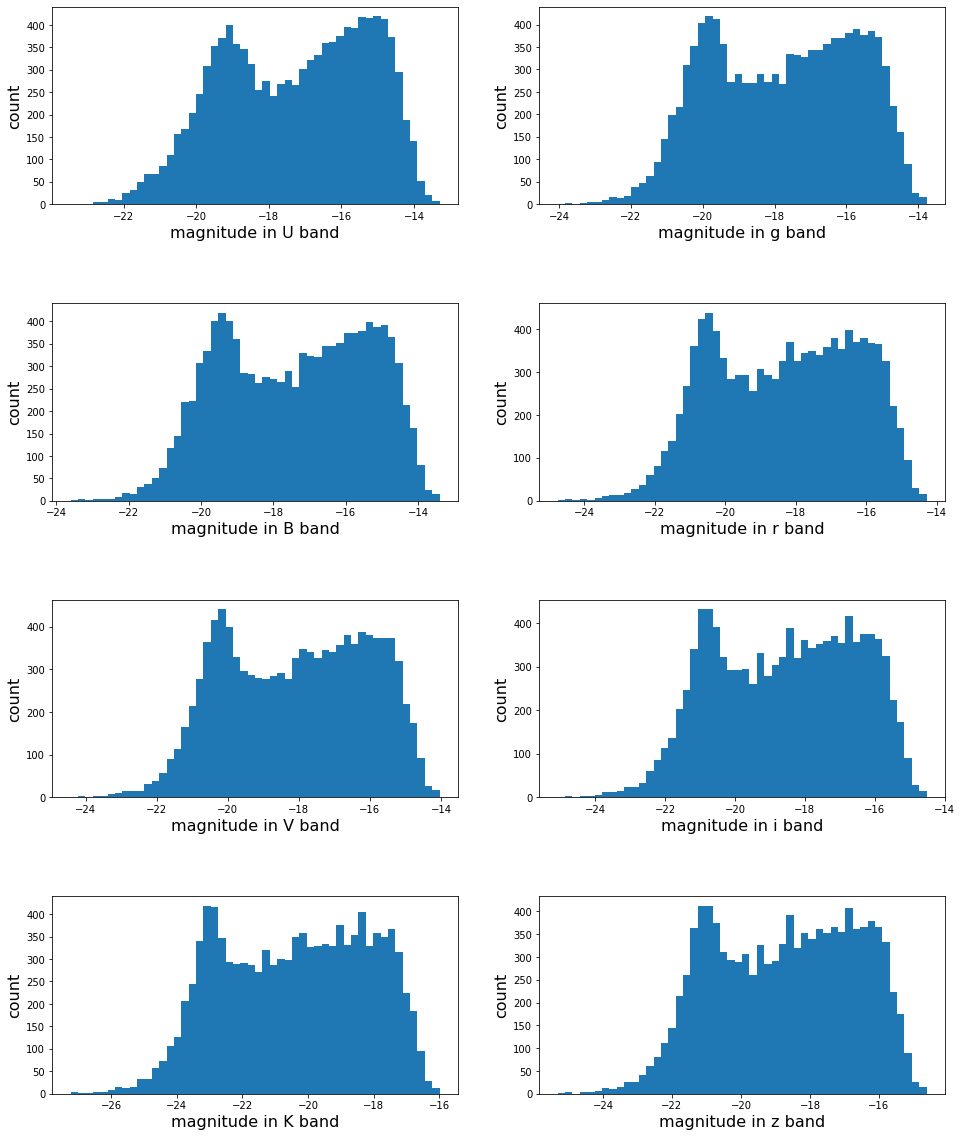

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


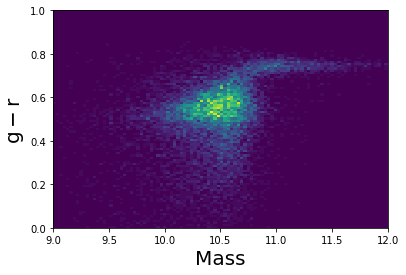

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


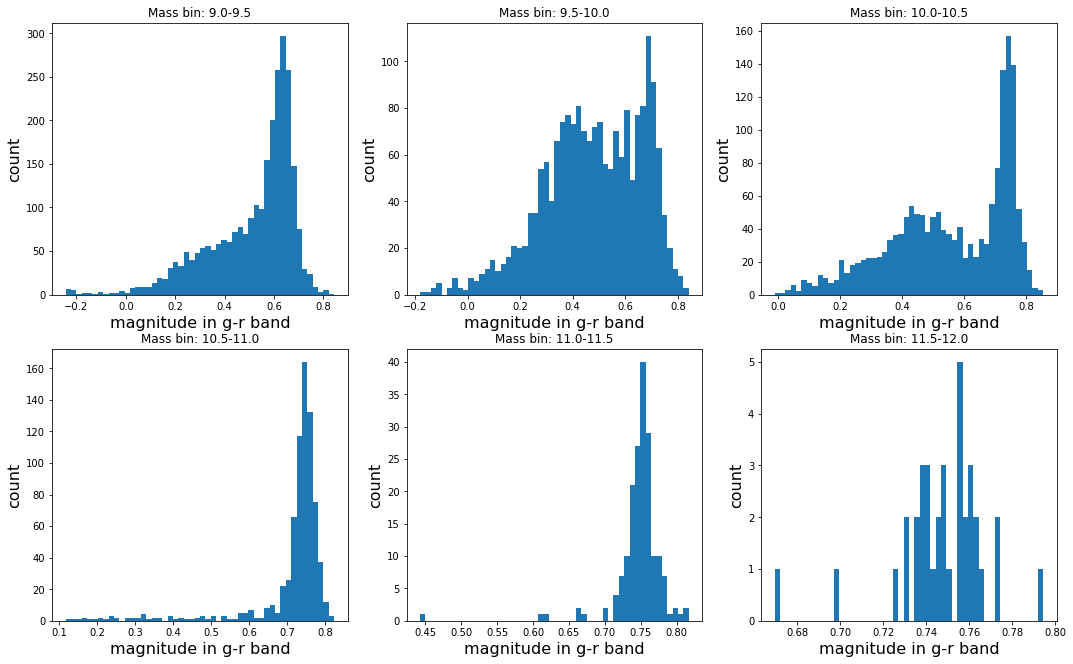

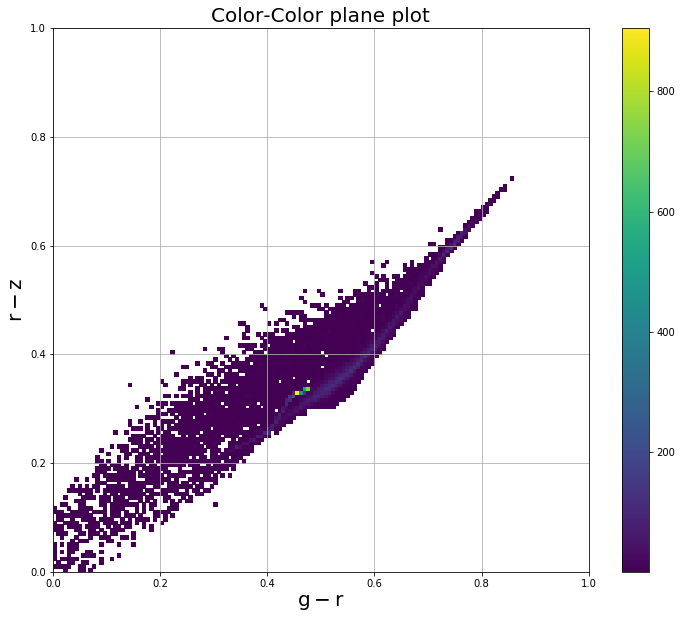

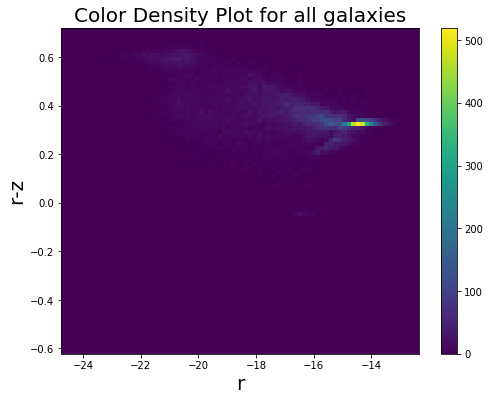

In [16]:
plot_all_bands(all_galaxies)
mass_vs_gmr(all_galaxies)
gmr_mass_bins_hist(all_galaxies)
color_color(all_galaxies['SubhaloStellarPhotometrics'], 0.0, 0.0)
color_density(all_galaxies['SubhaloStellarPhotometrics'], 5, 5, 7, "Color Density Plot for all galaxies")

